# 16. Parameter fitting

## Numerical experiments - Week 20/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using BlackBoxOptim
using JLD2
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./datautils.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .DataUtils

## 1. Time-dependent Dantigny dataset generation

The estimated $P_{\textrm{max}}$, $\tau_g$ and $\nu$ parameters from Ijadpanahsaravi et al. [1] allow the reconstruction of time-dependent courses of the germination percentage. This is useful for providing more data points to fit the different inducer-inhibitor interaction models outlined in the previous notebook.

The data points for the arginine-rich medium are removed, since they have a broad variance and semi-saturation times longer than the documented time period.

In [2]:
t_max = 48
df_germination_rebuilt = parse_ijadpanahsaravi_data()
df_germination_rebuilt = filter(row -> row[1] != "Arg", df_germination_rebuilt) # Remove "Arg" from the dataset
dantigny_data, times, sources, densities, errs, p_maxs, taus, nus = generate_dantigny_dataset(df_germination_rebuilt, t_max)
size(dantigny_data)

(2, 4, 1000)

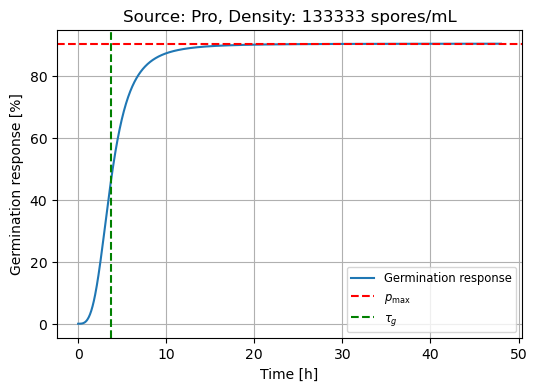

In [117]:
src_idx = 2
density_idx = 3
# params_data = filter(row -> (row[:CarbonSource] == sources[src_idx]) && (row[:Density] == densities[density_idx]), df_germination_rebuilt)
plot_dantigny_time_course(p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                            germination_responses=dantigny_data[src_idx, density_idx, :], times=times,
                            title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")

## 2. Fitting procedures for static inducer

The following parameter estimations are based on the assumption of a constant level of the carbon source at the receptor proteins, i.e. in the case when the hydrophobin-melanin layer does not impose any temporal delay on the carbon signalling. The objective function minimizes both the difference between time-dependent germination measurements and between steady-state equilibrium probabilities, weighing the latter by the number of time points to preserve its relative importance.

### 2.1. Independent induction/inhibition

As determined previously, the germination probability in the first model follows the formula

$$
\begin{equation}
p(\textrm{germination})=\Phi{\left(\frac{s-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

In the equilibrium limit, this probability becomes

$$
\begin{equation}
p(\textrm{germination})=\Phi{\left(\frac{s-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

In [175]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-20, 1e-4),
    :σ_γ => (1e-20, 1e-4),
    :s => (1e-12, 10.0),
    :μ_ω => (1e-12, 1.0),
    :σ_ω => (1e-12, 1.0)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("independent", def_params, dantigny_data, times, sources, densities, bounds, p_maxs * 0.01, max_steps=max_steps)

jldopen("Data/fit_independent.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.88 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=613.272459800
1.69 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.0000), fitness=292.600657032
2.60 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=292.600657032
3.56 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=179.837726198
4.44 secs, 10 evals, 5 steps, improv/step: 0.200 (last = 0.0000), fitness=179.837726198
5.51 secs, 12 evals, 6 steps, improv/step: 0.167 (last = 0.0000), fitness=179.837726198
6.61 secs, 14 evals, 7 steps, improv/step: 0.143 (last = 0.0000), fitness=179.837726198
7.70 secs, 16 evals, 8 steps, improv/step: 0.250 (last = 1.0000), fitness=179.837726198
9.01 secs, 18 evals, 9 steps, improv/step: 0.222 (last = 0.0000), fitness=179.837726198
9.84 sec

0.14201279030575908

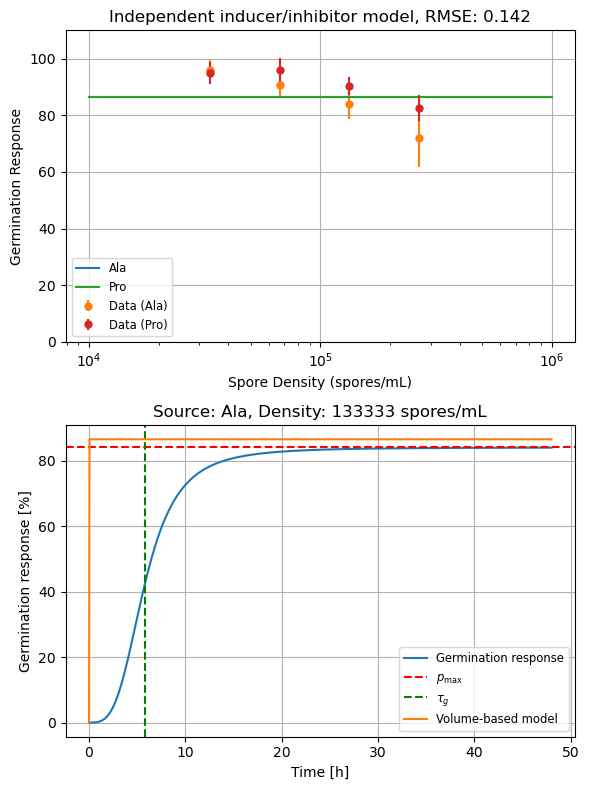

In [178]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_independent.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

s = params_opt[:s]
μ_ω = params_opt[:μ_ω]
σ_ω = params_opt[:σ_ω]
Pₛ = params_opt[:Pₛ]
μ_γ = params_opt[:μ_γ]
σ_γ = params_opt[:σ_γ]

src_idx = 1
density_idx = 3

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germination_response_combined_independent(s, μ_ω, σ_ω, Pₛ, sample_density, μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_density in density_range]
germ_resp_sample = germination_response_combined_independent(s, μ_ω, σ_ω, Pₛ, densities[density_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Independent inducer/inhibitor model, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

The model does not appear to reproduce the expected time course of the Dantigny model or an accurate representation of the dataset.

### 2.2. Inducer-modulated inhibition

In the second group of models, the germination depends on the depletion of the inhibitor and the inducer affects either the rate of release (as represented by the permeability), the threshold for inhibition, or both. The germination probability is expressed as

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}})}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

#### 2.2.1. Inducer shifts inhibition threshold

In the first case, it is assumed that the permeability remains constant over all inducing media, but it is the inhibition threshold that changes. Therefore, the $\gamma$ parameter is split into three cases, corresponding to the three carbon sources.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-20, 1e-4),
    :σ_γ => (1e-20, 1e-4)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inhibitor_thresh", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
3.09 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=829.909666331
6.33 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.0000), fitness=145.724741540
9.89 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 1.0000), fitness=145.724741540
11.66 secs, 7 evals, 4 steps, improv/step: 0.750 (last = 1.0000), fitness=145.724741540
15.12 secs, 9 evals, 5 steps, improv/step: 0.800 (last = 1.0000), fitness=145.724741540
18.14 secs, 11 evals, 6 steps, improv/step: 0.833 (last = 1.0000), fitness=145.724741540
21.19 secs, 13 evals, 7 steps, improv/step: 0.857 (last = 1.0000), fitness=145.724741540
24.21 secs, 15 evals, 8 steps, improv/step: 0.750 (last = 0.0000), fitness=145.724741540
27.24 secs, 17 evals, 9 steps, improv/step: 0.667 (last = 0.0000), fitness=145.724741540
30.

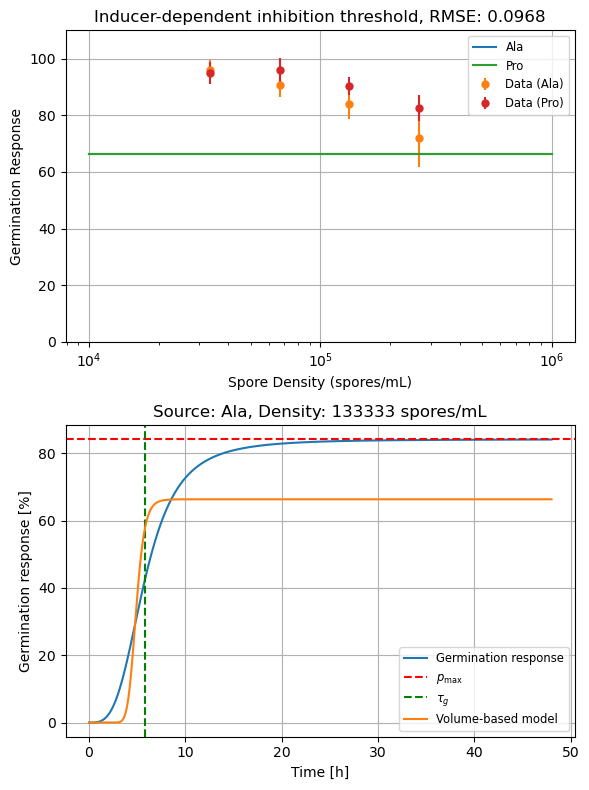

In [165]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inhibitor_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

Pₛ = params_opt[:Pₛ]
μ_γs = params_opt[:μ_γ]
σ_γs = params_opt[:σ_γ]

src_idx = 1
density_idx = 3

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germination_response_simple(densities[density_idx], Pₛ, μ_γs[src_idx], σ_γs[src_idx], def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_density in density_range]
germ_resp_sample = germination_response_simple(densities[density_idx], Pₛ, μ_γs[src_idx], σ_γs[src_idx], def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inducer-dependent inhibition threshold, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

#### 2.2.2. Inducer increases inhibitor permeation

In the second case, it is assumed that the inhibitor enhances the permeability of the inhibitor through the cell wall, accelerating its release. Hence, the threshold of inhibition remains the same, but $P_s$ varies across the carbon sources.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-20, 1e-4),
    :σ_γ => (1e-20, 1e-4)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inhibitor_perm", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor_perm.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.77 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.5000), fitness=267.983626909
1.54 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 1.0000), fitness=249.526272421
2.20 secs, 12 evals, 6 steps, improv/step: 0.667 (last = 0.5000), fitness=249.526272421
2.83 secs, 16 evals, 8 steps, improv/step: 0.625 (last = 0.5000), fitness=249.526272421
3.63 secs, 21 evals, 11 steps, improv/step: 0.545 (last = 0.3333), fitness=249.526272421
4.26 secs, 25 evals, 14 steps, improv/step: 0.571 (last = 0.6667), fitness=249.526272421
5.00 secs, 29 evals, 16 steps, improv/step: 0.625 (last = 1.0000), fitness=249.526272421
5.79 secs, 33 evals, 18 steps, improv/step: 0.611 (last = 0.5000), fitness=249.526272421
6.43 secs, 37 evals, 20 steps, improv/step: 0.600 (last = 0.5000), fitness=249.526272421
7

0.10668986559668951

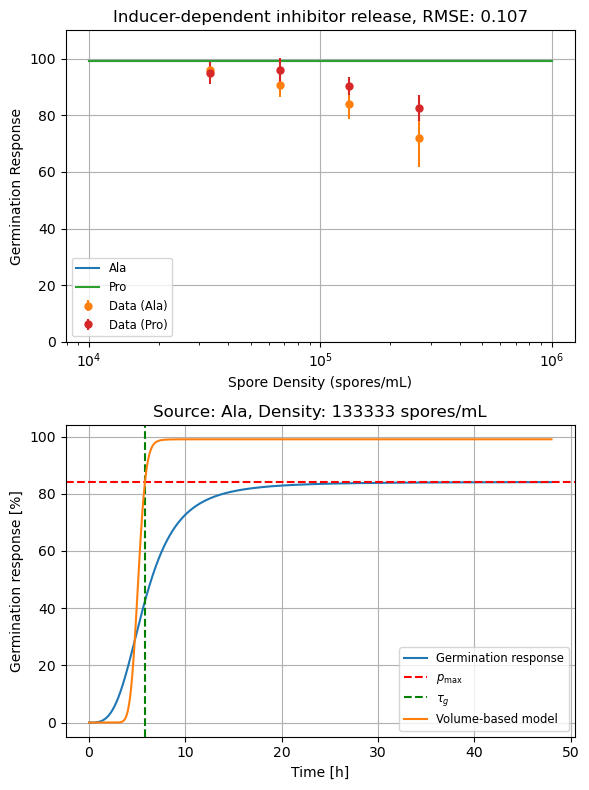

In [168]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inhibitor_perm.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

Pₛs = params_opt[:Pₛ]
μ_γ = params_opt[:μ_γ]
σ_γ = params_opt[:σ_γ]

src_idx = 1
density_idx = 3

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germination_response_simple(densities[density_idx], Pₛs[src_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_density in density_range]
germ_resp_sample = germination_response_simple(densities[density_idx], Pₛs[src_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inducer-dependent inhibitor release, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

#### 2.2.3. Inducer shifts inhibition threshold and increases inhibitor permeation

As a third option, the inducer is assumed to modulate both the inhibition threshold and the inhibitor permeation, making these parameters specific to each carbon source case.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-20, 1e-4),
    :σ_γ => (1e-20, 1e-4)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inhibitor", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.65 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=260.612039365
1.30 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 0.0000), fitness=260.612039365
1.92 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 0.5000), fitness=260.612039365
2.53 secs, 16 evals, 8 steps, improv/step: 0.500 (last = 0.5000), fitness=260.612039365
3.07 secs, 19 evals, 10 steps, improv/step: 0.500 (last = 0.5000), fitness=260.612039365
3.65 secs, 23 evals, 12 steps, improv/step: 0.417 (last = 0.0000), fitness=260.612039365
4.24 secs, 27 evals, 14 steps, improv/step: 0.429 (last = 0.5000), fitness=260.612039365
4.91 secs, 31 evals, 16 steps, improv/step: 0.375 (last = 0.0000), fitness=260.612039365
5.59 secs, 35 evals, 18 steps, improv/step: 0.333 (last = 0.0000), fitness=260.612039365
6

0.10701159686063141

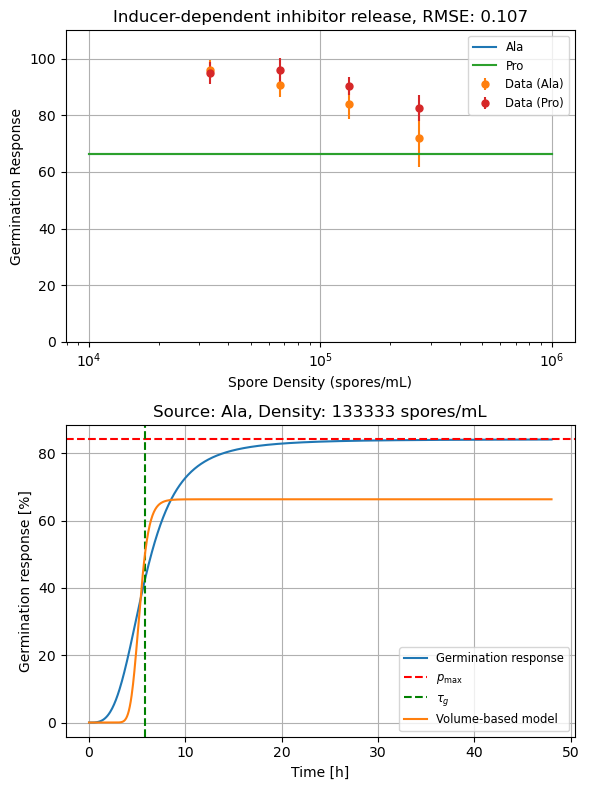

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inhibitor_perm.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

Pₛs = params_opt[:Pₛ]
μ_γ = params_opt[:μ_γ]
σ_γ = params_opt[:σ_γ]

src_idx = 1
density_idx = 3

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germination_response_simple(densities[density_idx], Pₛs[src_idx], μ_γs[src_idx], σ_γs[src_idx], def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_density in density_range]
germ_resp_sample = germination_response_simple(densities[density_idx], Pₛs[src_idx], μ_γs[src_idx], σ_γs[src_idx], def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inducer-dependent inhibitor release, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

### 2.3. Inducer-modulated carbon sensitivity

The third group of models examines the case in which the carbon source inducer triggers the germination programme, but its threshold or signalling strength are affected negatively by the presence of the inhibitor.

#### 2.3.1. Inhibitor shifts inducer threshold

In the first case, the residial concentration of inhibitor in the spore is assumed to shift the activation threshold for the carbon signalling. The germination probability is defined as follows:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}},
\end{equation}
$$

with

$$
\begin{equation}
f_\psi{(\psi)} = \frac{1}{\sqrt{2\pi}\sigma_\psi}e^{-\frac{(\psi-\mu_\psi)^2}{2\sigma_\psi^2}},
\end{equation}
$$

$$
\begin{equation}
f_\xi{(\xi)} = \frac{1}{\sqrt{2\pi}\sigma_\xi}e^{-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}}.
\end{equation}
$$

The signal strength $s$ is source-specific, while $k$, $\mu_{\omega_0}$ and $\sigma_{\omega_0}$ remain constant over the medium compositions.

#### 2.3.2. Inhibitor attenuates inducing signal

## References

- [1] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .